In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
import tensorflow.keras.layers as L
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow.keras import layers
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
batch_size = 6
lr = 1e-3
epochs = 300
width = 256
height = 256

In [3]:
dataset_path = os.path.join("/kaggle/input/aerosca/aeroscapes")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [4]:
def load_data(path):
    Images = sorted(glob(os.path.join(path, "JPEGImages", "*")))
    Labels = sorted(glob(os.path.join(path, "Visualizations", "*")))

    return (Images, Labels)

In [5]:
(Images, Labels) = load_data(dataset_path)

print(f"New Train: {len(Images)} - {len(Labels)}")

# First, split off 10% of the data for testing
train_val_images, test_x, train_val_labels, test_y = train_test_split(Images, Labels, test_size=0.1, random_state=42)

# Then, split the remaining 90% into 70% training and 20% validation (0.7 / 0.9 ≈ 0.78)
train_x, valid_x, train_y, valid_y = train_test_split(train_val_images, train_val_labels, test_size=0.22, random_state=42)

print(f"Training set: {len(train_x)} images")
print(f"Validation set: {len(valid_x)} images")
print(f"Test set: {len(test_x)} images")

New Train: 3269 - 3269
Training set: 2294 images
Validation set: 648 images
Test set: 327 images


In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [7]:
color_map = {
    (0, 0, 0): 0,            # Background
    (192, 128, 128): 1,      # Person
    (0, 128, 0): 2,          # Bike
    (128, 128, 128): 3,      # Car
    (128, 0, 0): 4,          # Drone
    (0, 0, 128): 5,          # Boat
    (192, 0, 128): 6,        # Animal
    (192, 0, 0): 7,          # Obstacle
    (192, 128, 0): 8,        # Construction
    (0, 64, 0): 9,           # Vegetation
    (128, 128, 0): 10,       # Road
    (0, 128, 128): 11,       # Sky
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    class_indices = np.zeros((height, width), dtype=np.uint8)
    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx
    
    # Convert to one-hot encoding
    one_hot_mask = tf.one_hot(class_indices, depth=12)  # 8 classes as per your color_map
    return one_hot_mask.numpy()

In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 12])  # 8 classes
    return x, y

In [9]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

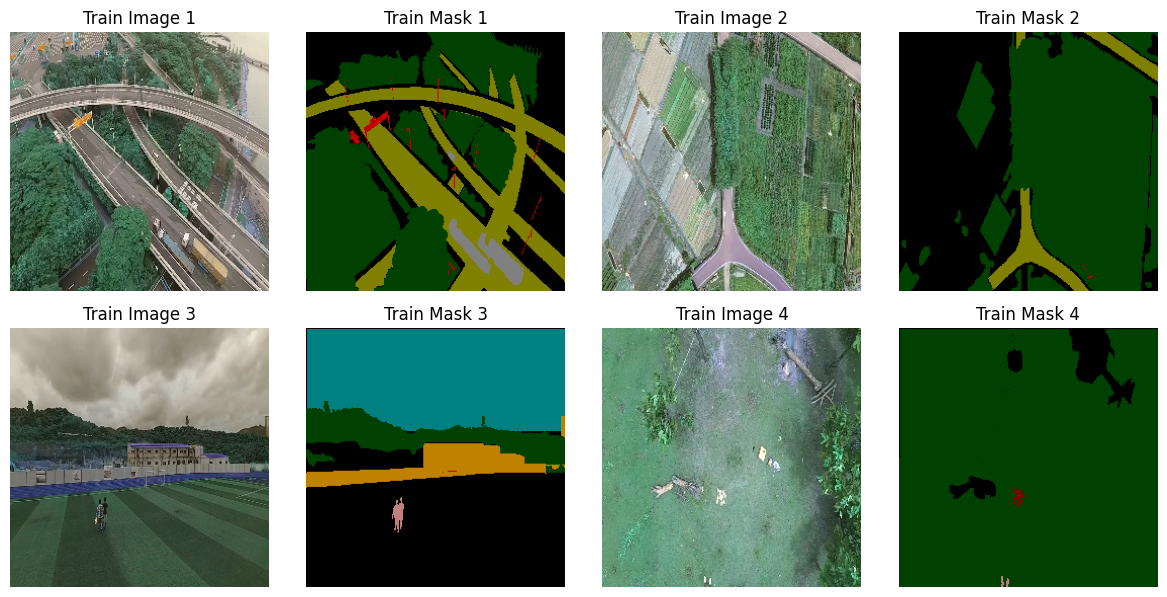

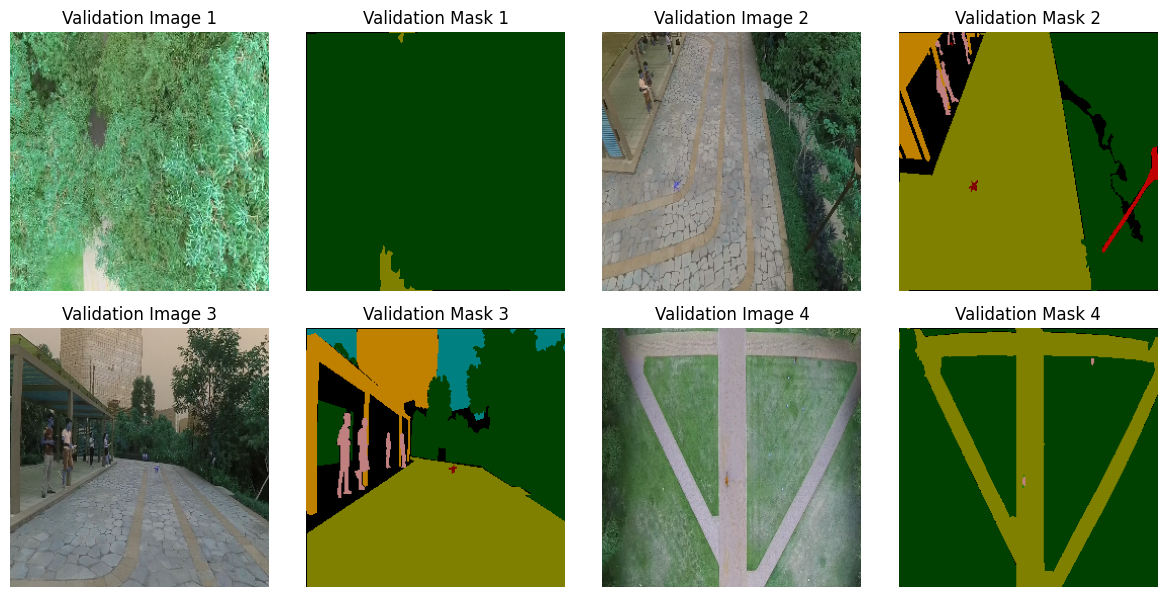

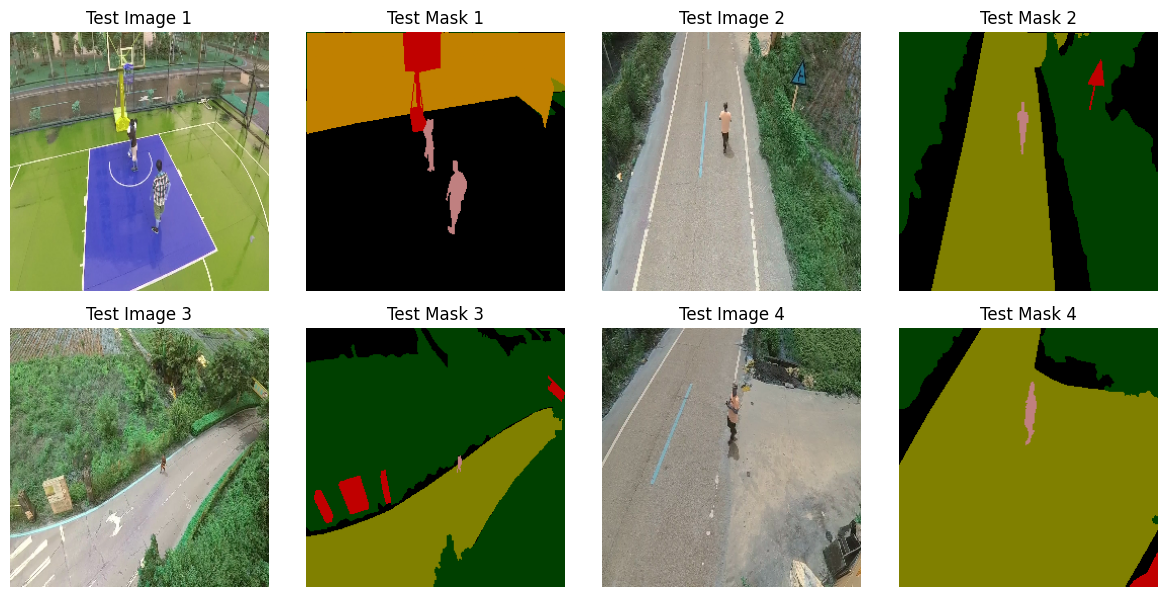

In [11]:
# Create a custom color map based on the color_map dictionary
color_map_values = list(color_map.keys())
color_map_rgb = np.array(color_map_values) / 255.0  # Normalize to 0-1 range for matplotlib

def plot_samples_with_labels(dataset, title):
    plt.figure(figsize=(12, 12))
    for i, (images, masks) in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(4):  # Loop over first four images
            # Plot the image
            plt.subplot(4, 4, j*2 + 1)
            plt.imshow(images[j].numpy())
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Image {j+1}")

            # Convert one-hot mask back to class indices
            class_indices = np.argmax(masks[j].numpy(), axis=-1)

            # Convert class indices to RGB colors
            mask_rgb = np.zeros((height, width, 3), dtype=np.float32)
            for idx, color in enumerate(color_map_rgb):
                mask_rgb[class_indices == idx] = color

            # Plot the label mask
            plt.subplot(4, 4, j*2 + 2)
            plt.imshow(mask_rgb)
            plt.axis("off")
            plt.title(f"{['Train', 'Validation', 'Test'][title]} Mask {j+1}")
    
    plt.tight_layout()
    plt.show()


# Plot the images and corresponding label masks for each dataset
plot_samples_with_labels(train_dataset, title=0)   # Train images and masks
plot_samples_with_labels(valid_dataset, title=1)   # Validation images and masks
plot_samples_with_labels(test_dataset, title=2)    # Test images and masks

In [12]:
import tensorflow as tf
from tensorflow.keras import layers as L

def scse_module(x):
    """ SCSE (Squeeze-and-Excitation + Spatial Attention) Module """
    
    # Channel Attention (SE Block)
    ch_avg = L.GlobalAveragePooling2D()(x)
    ch_avg = L.Dense(x.shape[-1] // 2, activation="relu")(ch_avg)
    ch_avg = L.Dense(x.shape[-1], activation="sigmoid")(ch_avg)
    ch_avg = L.Reshape((1, 1, x.shape[-1]))(ch_avg)
    x_ch = L.Multiply()([x, ch_avg])

    # Spatial Attention
    spatial = L.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x_sp = L.Multiply()([x, spatial])

    # Combining both attentions
    x_out = L.Add()([x_ch, x_sp])
    return x_out

In [13]:
def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)
    x = scse_module(x)  # Replacing CBAM with SCSE
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=12):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = scse_module(e5)  # Replacing CBAM with SCSE
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = scse_module(d4)  # Replacing CBAM with SCSE
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = scse_module(d3)  # Replacing CBAM with SCSE
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = scse_module(d2)  # Replacing CBAM with SCSE
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = scse_module(d1)  # Replacing CBAM with SCSE
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("softmax")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model

In [14]:
input_shape = (height, width, 3)
num_classes = 12

# Instantiate the model
model = unet3plus(input_shape, num_classes)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          2,080 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          2,112 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 1)    │             65 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 256, 64)   │              0 │ activation_1[0][0],    │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 256, 256, 64)   │              0 │ activation_1[0][0],    │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ multiply[0][0],        │
│                           │                        │                │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 28,831,029 (109.98 MB)

 Trainable params: 28,817,973 (109.93 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [16]:
alpha = 0.25
gamma = 2.0

# Compile the model with focal loss
opt = tf.keras.optimizers.Adam(lr)
model.compile(
    loss=tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=gamma,
        from_logits=False  # Since we have softmax activation in the final layer
    ),
    optimizer=opt,
    metrics=['categorical_accuracy']
)

In [17]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [18]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6809 - loss: 0.1308   
Epoch 1: val_loss improved from inf to 0.14484, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 573s 1s/step - categorical_accuracy: 0.6811 - loss: 0.1307 - val_categorical_accuracy: 0.3988 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 2/300
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - categorical_accuracy: 0.7862 - loss: 0.0695
Epoch 2: val_loss improved from 0.14484 to 0.11601, saving model to files/modified_uavid_dataset/UnetModel.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - categorical_accuracy: 0.7862 - loss: 0.0695 - val_categorical_accuracy: 0.7893 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 3/300
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - categorical_accuracy: 0.8198 - loss: 0.0573
Epoch 3: val_loss did not improve from 0.11601
383/383 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - categorical_accuracy: 0.8199 - loss: 0.0573 - val_ca

In [19]:
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [20]:
tf.keras.config.enable_unsafe_deserialization()
custom_objects = {
    "scse_module": scse_module,
}
model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

Index(['epoch', 'categorical_accuracy', 'learning_rate', 'loss',
       'val_categorical_accuracy', 'val_loss'],
      dtype='object')


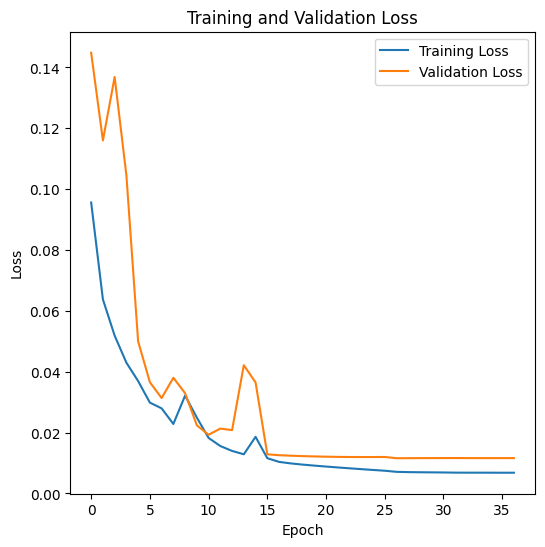

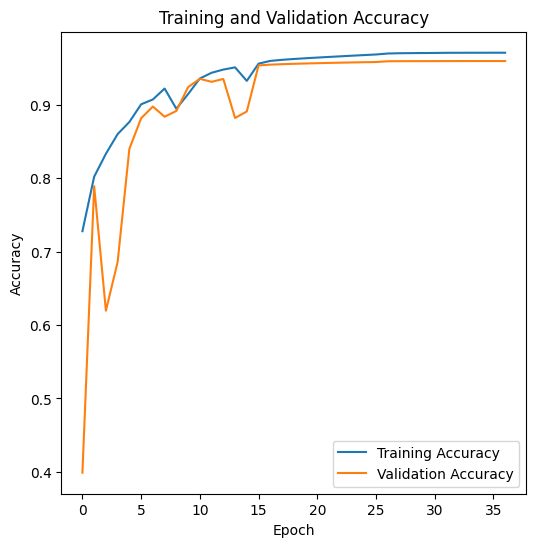

In [21]:
import pandas as pd
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


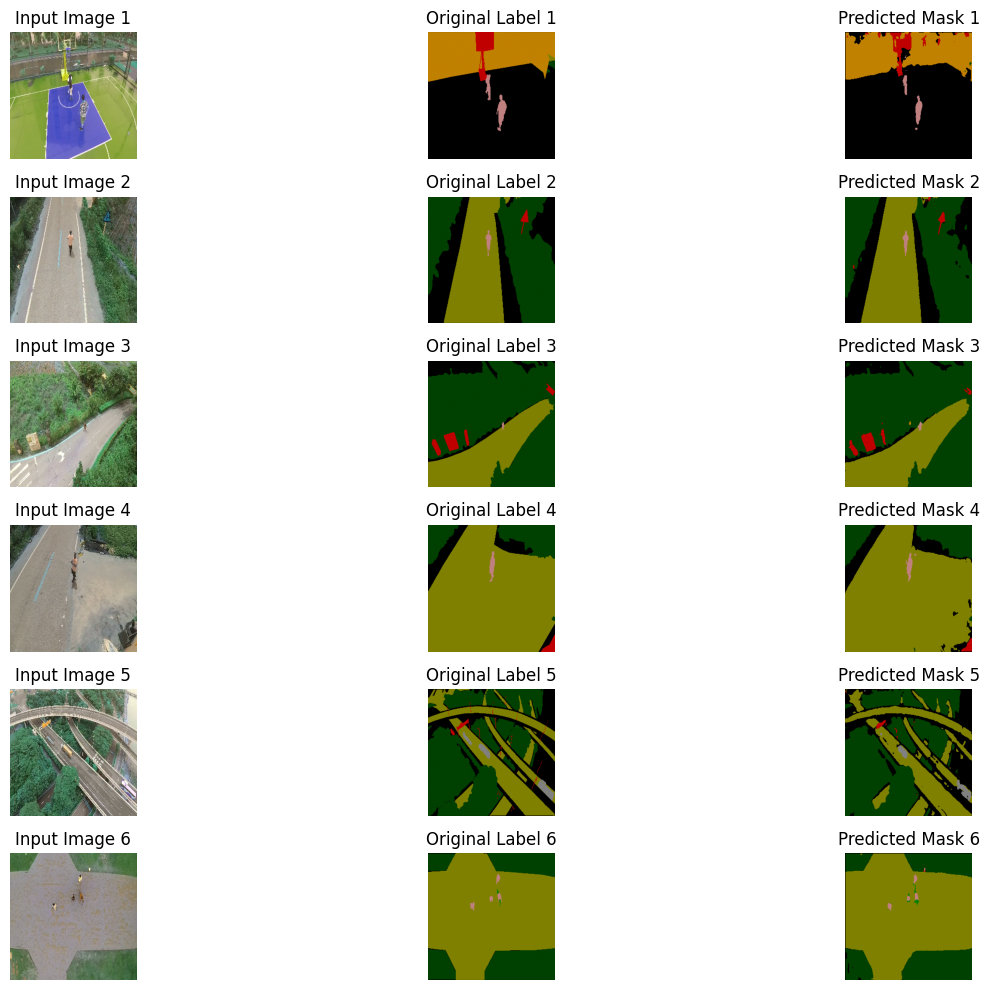

In [23]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(test_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = test_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
import time

# colors = [
#     (0, 0, 0),           # Background
#     (192, 128, 128),     # Person
#     (0, 128, 0),         # Bike
#     (128, 128, 128),     # Car
#     (128, 0, 0),         # Drone
#     (0, 0, 128),         # Boat
#     (192, 0, 128),       # Animal
#     (192, 0, 0),         # Obstacle
#     (192, 128, 0),       # Construction
#     (0, 64, 0),          # Vegetation
#     (128, 128, 0),       # Road
#     (0, 128, 128),       # Sky
# ]

time_taken = []
for x in tqdm(test_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/327 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 1/327 [00:00<00:43,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 2/327 [00:00<00:43,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 3/327 [00:00<00:42,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 4/327 [00:00<00:42,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 5/327 [00:00<00:42,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 6/327 [00:00<00:41,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 7/327 [00:00<00:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 8/327 [00:01<00:41,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 9/327 [00:01<00:41,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 10/327 [00:01<00:41,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 11/327 [00:01<00:41,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▎         | 12/327 [00:01<00:41,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 13/327 [00:01<00:42,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 14/327 [00:01<00:42,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 15/327 [00:01<00:42,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 16/327 [00:02<00:42,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 17/327 [00:02<00:42,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 18/327 [00:02<00:42,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 19/327 [00:02<00:42,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 20/327 [00:02<00:43,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▋         | 21/327 [00:02<00:42,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 22/327 [00:02<00:42,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 23/327 [00:03<00:42,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 24/327 [00:03<00:42,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 25/327 [00:03<00:41,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 26/327 [00:03<00:41,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 27/327 [00:03<00:41,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▊         | 28/327 [00:03<00:41,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 29/327 [00:03<00:41,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 30/327 [00:04<00:41,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 31/327 [00:04<00:40,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 32/327 [00:04<00:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 33/327 [00:04<00:40,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 34/327 [00:04<00:39,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 35/327 [00:04<00:40,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 36/327 [00:04<00:40,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█▏        | 37/327 [00:05<00:40,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 38/327 [00:05<00:39,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 39/327 [00:05<00:39,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 40/327 [00:05<00:39,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 41/327 [00:05<00:39,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 42/327 [00:05<00:39,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 43/327 [00:05<00:39,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 44/327 [00:06<00:39,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 45/327 [00:06<00:39,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 46/327 [00:06<00:38,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 47/327 [00:06<00:38,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 48/327 [00:06<00:38,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 49/327 [00:06<00:37,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 50/327 [00:06<00:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 51/327 [00:06<00:37,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 52/327 [00:07<00:37,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 53/327 [00:07<00:38,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 54/327 [00:07<00:39,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 55/327 [00:07<00:38,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 56/327 [00:07<00:38,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 57/327 [00:07<00:37,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 58/327 [00:07<00:37,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 59/327 [00:08<00:37,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 60/327 [00:08<00:37,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▊        | 61/327 [00:08<00:37,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 62/327 [00:08<00:37,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 63/327 [00:08<00:37,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|█▉        | 64/327 [00:08<00:36,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|█▉        | 65/327 [00:08<00:36,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|██        | 66/327 [00:09<00:36,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 67/327 [00:09<00:36,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 68/327 [00:09<00:35,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 69/327 [00:09<00:36,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██▏       | 70/327 [00:09<00:35,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 71/327 [00:09<00:35,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 72/327 [00:09<00:35,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 73/327 [00:10<00:35,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 74/327 [00:10<00:35,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 75/327 [00:10<00:34,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 76/327 [00:10<00:34,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▎       | 77/327 [00:10<00:34,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 78/327 [00:10<00:34,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 79/327 [00:10<00:34,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 80/327 [00:11<00:34,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 81/327 [00:11<00:34,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 82/327 [00:11<00:34,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 83/327 [00:11<00:33,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 84/327 [00:11<00:33,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 85/327 [00:11<00:33,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 86/327 [00:11<00:33,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 87/327 [00:11<00:32,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 88/327 [00:12<00:32,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 89/327 [00:12<00:32,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 90/327 [00:12<00:32,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 91/327 [00:12<00:32,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 92/327 [00:12<00:32,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 93/327 [00:12<00:32,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 94/327 [00:12<00:32,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 95/327 [00:13<00:32,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 96/327 [00:13<00:32,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 97/327 [00:13<00:32,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 98/327 [00:13<00:31,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 99/327 [00:13<00:31,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 100/327 [00:13<00:31,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 101/327 [00:13<00:31,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 102/327 [00:14<00:31,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███▏      | 103/327 [00:14<00:30,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 104/327 [00:14<00:30,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 105/327 [00:14<00:30,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 106/327 [00:14<00:30,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 107/327 [00:14<00:30,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 108/327 [00:14<00:30,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 109/327 [00:15<00:30,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 110/327 [00:15<00:29,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 111/327 [00:15<00:29,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 112/327 [00:15<00:29,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 113/327 [00:15<00:30,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▍      | 114/327 [00:15<00:29,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 115/327 [00:15<00:29,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 116/327 [00:16<00:29,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 117/327 [00:16<00:28,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 118/327 [00:16<00:28,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▋      | 119/327 [00:16<00:28,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 120/327 [00:16<00:28,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 121/327 [00:16<00:28,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 122/327 [00:16<00:28,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 123/327 [00:16<00:27,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 124/327 [00:17<00:27,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 125/327 [00:17<00:28,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▊      | 126/327 [00:17<00:29,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 127/327 [00:17<00:28,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 128/327 [00:17<00:28,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 129/327 [00:17<00:27,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 130/327 [00:17<00:27,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 131/327 [00:18<00:27,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 132/327 [00:18<00:26,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 133/327 [00:18<00:26,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 134/327 [00:18<00:26,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 135/327 [00:18<00:26,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 136/327 [00:18<00:26,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 137/327 [00:18<00:26,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 138/327 [00:19<00:26,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 139/327 [00:19<00:26,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 140/327 [00:19<00:25,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 141/327 [00:19<00:25,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 142/327 [00:19<00:25,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 143/327 [00:19<00:25,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▍     | 144/327 [00:19<00:26,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 145/327 [00:20<00:26,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 146/327 [00:20<00:26,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 147/327 [00:20<00:26,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▌     | 148/327 [00:20<00:26,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 149/327 [00:20<00:26,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 150/327 [00:20<00:26,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 151/327 [00:20<00:25,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▋     | 152/327 [00:21<00:25,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 153/327 [00:21<00:24,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 154/327 [00:21<00:24,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 155/327 [00:21<00:24,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 156/327 [00:21<00:23,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 157/327 [00:21<00:23,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 158/327 [00:21<00:23,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▊     | 159/327 [00:22<00:23,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 160/327 [00:22<00:23,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 161/327 [00:22<00:23,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 162/327 [00:22<00:23,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 163/327 [00:22<00:22,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 164/327 [00:22<00:22,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 165/327 [00:22<00:22,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████     | 166/327 [00:23<00:22,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 167/327 [00:23<00:22,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████▏    | 168/327 [00:23<00:22,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 169/327 [00:23<00:22,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 170/327 [00:23<00:21,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 171/327 [00:23<00:21,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 172/327 [00:23<00:21,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 173/327 [00:24<00:21,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 174/327 [00:24<00:21,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▎    | 175/327 [00:24<00:21,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 176/327 [00:24<00:21,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 177/327 [00:24<00:20,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 178/327 [00:24<00:20,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 179/327 [00:24<00:20,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 180/327 [00:24<00:20,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 181/327 [00:25<00:20,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 182/327 [00:25<00:20,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 183/327 [00:25<00:20,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 184/327 [00:25<00:19,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 185/327 [00:25<00:19,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 186/327 [00:25<00:19,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 187/327 [00:25<00:19,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 188/327 [00:26<00:19,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 189/327 [00:26<00:19,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 190/327 [00:26<00:19,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 191/327 [00:26<00:19,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 192/327 [00:26<00:18,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 193/327 [00:26<00:18,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 194/327 [00:26<00:18,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 195/327 [00:27<00:18,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 196/327 [00:27<00:18,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 60%|██████    | 197/327 [00:27<00:18,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 198/327 [00:27<00:18,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 199/327 [00:27<00:18,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 200/327 [00:27<00:17,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 201/327 [00:27<00:17,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 202/327 [00:28<00:17,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 203/327 [00:28<00:17,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 204/327 [00:28<00:17,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 205/327 [00:28<00:17,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 206/327 [00:28<00:16,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 207/327 [00:28<00:16,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▎   | 208/327 [00:28<00:16,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 209/327 [00:29<00:16,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 210/327 [00:29<00:16,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 211/327 [00:29<00:16,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 212/327 [00:29<00:15,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▌   | 213/327 [00:29<00:15,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 214/327 [00:29<00:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 215/327 [00:29<00:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 216/327 [00:29<00:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▋   | 217/327 [00:30<00:15,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 218/327 [00:30<00:15,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 219/327 [00:30<00:14,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 220/327 [00:30<00:14,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 221/327 [00:30<00:14,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 222/327 [00:30<00:14,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 223/327 [00:30<00:14,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▊   | 224/327 [00:31<00:14,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 225/327 [00:31<00:14,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 226/327 [00:31<00:14,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▉   | 227/327 [00:31<00:13,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████▉   | 228/327 [00:31<00:13,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 229/327 [00:31<00:13,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 230/327 [00:31<00:13,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 231/327 [00:32<00:13,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 232/327 [00:32<00:13,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 233/327 [00:32<00:13,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 234/327 [00:32<00:13,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 235/327 [00:32<00:12,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 236/327 [00:32<00:12,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 237/327 [00:32<00:12,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 238/327 [00:33<00:12,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 239/327 [00:33<00:12,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 240/327 [00:33<00:12,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 241/327 [00:33<00:12,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▍  | 242/327 [00:33<00:11,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▍  | 243/327 [00:33<00:11,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 244/327 [00:33<00:11,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 245/327 [00:34<00:11,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▌  | 246/327 [00:34<00:11,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 247/327 [00:34<00:11,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 248/327 [00:34<00:11,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 249/327 [00:34<00:10,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▋  | 250/327 [00:34<00:10,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 251/327 [00:34<00:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 252/327 [00:35<00:10,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 253/327 [00:35<00:10,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 254/327 [00:35<00:10,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 255/327 [00:35<00:09,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 256/327 [00:35<00:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▊  | 257/327 [00:35<00:09,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 258/327 [00:35<00:09,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 259/327 [00:36<00:10,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 260/327 [00:36<00:09,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 261/327 [00:36<00:09,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 262/327 [00:36<00:09,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 263/327 [00:36<00:09,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 264/327 [00:36<00:08,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 265/327 [00:36<00:08,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████▏ | 266/327 [00:36<00:08,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 267/327 [00:37<00:08,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 268/327 [00:37<00:08,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 269/327 [00:37<00:08,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 270/327 [00:37<00:08,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 271/327 [00:37<00:07,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 272/327 [00:37<00:07,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 273/327 [00:37<00:07,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 274/327 [00:38<00:07,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 275/327 [00:38<00:07,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 276/327 [00:38<00:07,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 277/327 [00:38<00:06,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 278/327 [00:38<00:06,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 279/327 [00:38<00:06,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 280/327 [00:38<00:06,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 281/327 [00:39<00:06,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 282/327 [00:39<00:06,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 283/327 [00:39<00:06,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 284/327 [00:39<00:06,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 285/327 [00:39<00:05,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 286/327 [00:39<00:05,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 287/327 [00:39<00:05,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 288/327 [00:40<00:05,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 289/327 [00:40<00:05,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▊ | 290/327 [00:40<00:05,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 291/327 [00:40<00:04,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 292/327 [00:40<00:04,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 293/327 [00:40<00:04,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 294/327 [00:40<00:04,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████ | 295/327 [00:41<00:04,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 296/327 [00:41<00:04,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 297/327 [00:41<00:04,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 91%|█████████ | 298/327 [00:41<00:04,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 299/327 [00:41<00:03,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 300/327 [00:41<00:03,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 301/327 [00:41<00:03,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 302/327 [00:42<00:03,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 303/327 [00:42<00:03,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 304/327 [00:42<00:03,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 305/327 [00:42<00:03,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▎| 306/327 [00:42<00:02,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 307/327 [00:42<00:02,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 308/327 [00:42<00:02,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 309/327 [00:42<00:02,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▍| 310/327 [00:43<00:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 311/327 [00:43<00:02,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 312/327 [00:43<00:02,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 313/327 [00:43<00:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 314/327 [00:43<00:01,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▋| 315/327 [00:43<00:01,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 316/327 [00:43<00:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 317/327 [00:44<00:01,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 318/327 [00:44<00:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 319/327 [00:44<00:01,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 320/327 [00:44<00:00,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 321/327 [00:44<00:00,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 322/327 [00:44<00:00,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 323/327 [00:44<00:00,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 324/327 [00:45<00:00,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 325/327 [00:45<00:00,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 326/327 [00:45<00:00,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 327/327 [00:45<00:00,  7.19it/s]


In [25]:
!zip -r AEROscse.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'AEROscse.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/files/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_loss.png (deflated 10%)
  adding: kaggle/working/files/modified_uavid_dataset/Log-Unet.csv (deflated 59%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_accuracy.png (deflated 10%)
  adding: kaggle/working/files/modified_uavid_dataset/UnetModel.keras (deflated 9%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_310014_032.jpg (deflated 6%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_045001_030.jpg (deflated 5%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscapes_000001_001.jpg (deflated 5%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/aeroscap

/kaggle/working/AEROscse.zip